In [2]:
import cv2
import time
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from collections import Counter

In [11]:

def split_dataset():
    A_train = np.empty((10304, 0))
    A_test = np.empty((10304, 0))
    
    try:
        for i in range(1, 41):
            for j in range(1, 9):
                path = f'C:/Users/Administrator/Desktop/ASC/att_faces/s{i}/{j}.pgm'
                poza = cv2.imread(path, 0)
                if poza is None:
                    raise FileNotFoundError(f"Could not read image: {path}")
                poza = poza.flatten()[:, np.newaxis]
                A_train = np.hstack((A_train, poza))
            
            for j in range(9, 11):
                path = f'C:/Users/Administrator/Desktop/ASC/att_faces/s{i}/{j}.pgm'
                poza = cv2.imread(path, 0)
                if poza is None:
                    raise FileNotFoundError(f"Could not read image: {path}")
                poza = poza.flatten()[:, np.newaxis]
                A_test = np.hstack((A_test, poza))
        
        return A_train, A_test
    except Exception as e:
        print(f"Error in split_dataset: {e}")
        return None

In [12]:
def norma_1(x):
    return np.linalg.norm(x, 1)

def norma_2(x):
    return np.linalg.norm(x, 2)

def norma_inf(x):
    return np.linalg.norm(x, np.inf)

def cosine_norm(x, y):
    return 1 - np.dot(x, y) / (np.linalg.norm(x) * np.linalg.norm(y))

norms = {
    '1': norma_1,
    '2': norma_2,
    'inf': norma_inf,
    'cosine': cosine_norm
}

In [13]:
def KNN(A_train, test_image, norma, k=3):
    distances = []
    
    for i in range(A_train.shape[1]):
        train_image = A_train[:, i]
        
        if norma == cosine_norm:
            distance = norma(test_image, train_image)
        else:
            distance = norma(train_image - test_image)
        
        distances.append((distance, i))
    
    distances.sort(key=lambda x: x[0])
    k_nearest_neighbors = distances[:k]
    
    person_ids = [neighbor[1] // 8 for neighbor in k_nearest_neighbors]
    
    predicted_person = Counter(person_ids).most_common(1)[0][0]
    
    predicted_image_idx = k_nearest_neighbors[person_ids.index(predicted_person)][1]
    
    return predicted_person, A_train[:, predicted_image_idx]

In [14]:
def calculate_accuracy_knn(A_train, A_test, norms, k=3, norm_type='2'):
    correct_predictions = 0
    total_time = 0
    total_tests = A_test.shape[1] 
    
    selected_norm = norms[norm_type]
    
    for test_idx in range(total_tests):
        actual_person = test_idx // 2  
        test_image = A_test[:, test_idx]  
        
        t0 = time.time()
        predicted_person, predicted_image_idx = KNN(A_train, test_image, norma=selected_norm, k=k)
        t1 = time.time()

        total_time += (t1-t0)

        if predicted_person == actual_person:
            correct_predictions += 1
    
    accuracy = (correct_predictions / total_tests) * 100
    avg_time = (total_time / total_tests)

    return accuracy, avg_time

In [15]:
norm_choice = input("Enter the norm you want to use ('1', '2', 'inf', 'cosine'): ")

if norm_choice not in norms:
    print("Invalid norm choice! Please choose from '1', '2', 'inf', or 'cosine'.")
else:
    k_choice = input("Enter the value of k for KNN (e.g., 1, 3, 5, 7): ")
    
    try:
        k = int(k_choice)
        if k <= 0:
            raise ValueError("k must be a positive integer.")
    except ValueError as e:
        print(f"Invalid k value! {e}")
    else:
        A_train, A_test = split_dataset()  
        
        accuracy, avg_time = calculate_accuracy_knn(A_train, A_test, norms, k=k, norm_type=norm_choice)  
        
        print(f"Accuracy of K-th Nearest Neighbor classifier with k={k} and {norm_choice} norm: {accuracy:.2f}%")

Accuracy of K-th Nearest Neighbor classifier with k=1 and 2 norm: 95.00%


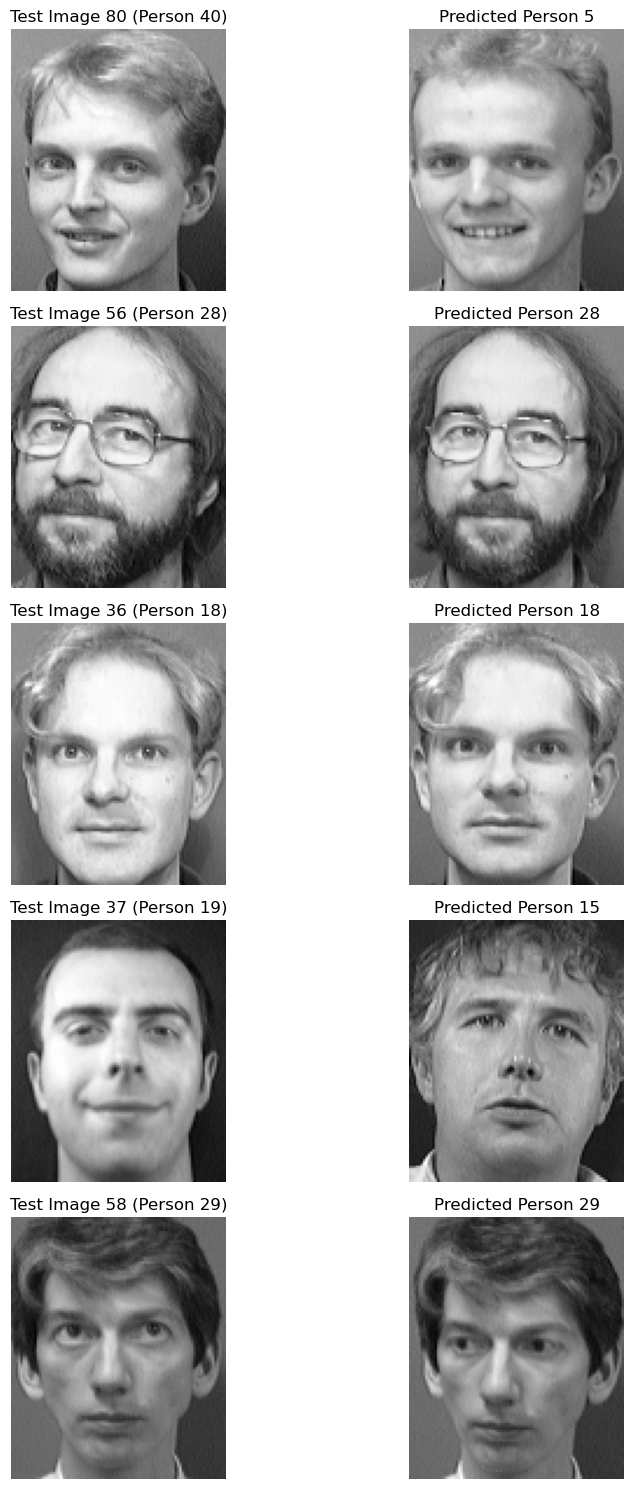

Accuracy for 5 test images using 2 norm with k=1: 60.00%


In [7]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import random

def test_predictions(A_train, A_test, norms, norm_type='2', k=1, num_images=5):
    correct_predictions = 0
    test_indices = random.sample(range(A_test.shape[1]), num_images) 
    
    fig, axes = plt.subplots(num_images, 2, figsize=(10, num_images * 3))
    
    for i, test_idx in enumerate(test_indices):
        actual_person = test_idx // 2
        
        test_image = A_test[:, test_idx]  
        predicted_person, predicted_image = KNN(A_train, test_image, norma=norms[norm_type], k=k)  
        
        ax1, ax2 = axes[i]
        ax1.imshow(test_image.reshape(112, 92), cmap='gray')
        ax1.set_title(f'Test Image {test_idx + 1} (Person {actual_person + 1})')
        ax1.axis('off')
        
        ax2.imshow(predicted_image.reshape(112, 92), cmap='gray') 
        ax2.set_title(f'Predicted Person {predicted_person + 1}')
        ax2.axis('off')
        
        if predicted_person == actual_person:
            correct_predictions += 1
    
    plt.tight_layout()
    plt.show()
    
    accuracy = correct_predictions / num_images * 100
    print(f"Accuracy for {num_images} test images using {norm_type} norm with k={k}: {accuracy:.2f}%")
    
k_choice = 1 
test_predictions(A_train, A_test, norms, norm_type='2', k=k_choice, num_images=5)

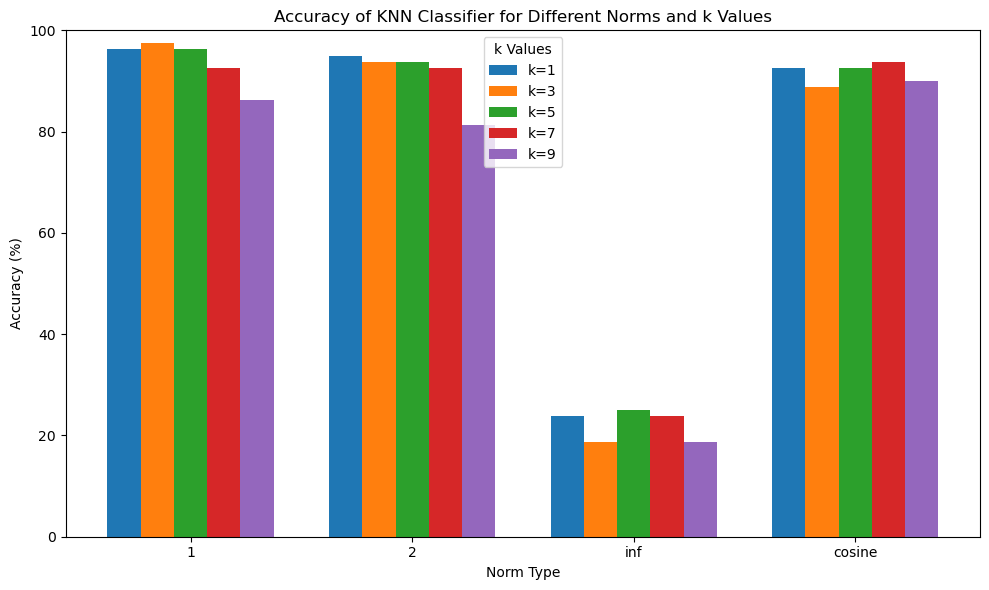

In [8]:
def plot_accuracy_for_norms_knn(A_train, A_test, norms, k_values=[1, 3, 5, 7]):
    accuracy_results = {k: {} for k in k_values}

    for k in k_values:
        for norm_name, norm_func in norms.items():
            accuracy, avg_time = calculate_accuracy_knn(A_train, A_test, norms, k=k, norm_type=norm_name)
            accuracy_results[k][norm_name] = accuracy
    
    fig, ax = plt.subplots(figsize=(10, 6))
    
    bar_width = 0.15
    index = np.arange(len(norms))
    
    for i, k in enumerate(k_values):
        accuracies = [accuracy_results[k][norm] for norm in norms]
        ax.bar(index + i * bar_width, accuracies, bar_width, label=f'k={k}')
    
    ax.set_xlabel('Norm Type')
    ax.set_ylabel('Accuracy (%)')
    ax.set_title('Accuracy of KNN Classifier for Different Norms and k Values')
    ax.set_xticks(index + (len(k_values) - 1) * bar_width / 2)
    ax.set_xticklabels(list(norms.keys()))
    ax.legend(title='k Values')
    ax.set_ylim([0, 100])
    
    plt.tight_layout()
    plt.show()

k_values = [1, 3, 5, 7, 9]
plot_accuracy_for_norms_knn(A_train, A_test, norms, k_values=k_values)

In [ ]:
def plot_avgtime_for_norms_knn(A_train, A_test, norms, k_values=[1, 3, 5, 7]):
    avg_time_results = {k: {} for k in k_values}

    for k in k_values:
        for norm_name, norm_func in norms.items():
            accuracy, avg_time = calculate_accuracy_knn(A_train, A_test, norms, k=k, norm_type=norm_name)
            avg_time_results[k][norm_name] = avg_time
    
    fig, ax = plt.subplots(figsize=(10, 6))
    
    bar_width = 0.15
    index = np.arange(len(norms))
    
    for i, k in enumerate(k_values):
        avg_times = [avg_time_results[k][norm] for norm in norms]
        ax.bar(index + i * bar_width, avg_times, bar_width, label=f'k={k}')
    
    ax.set_xlabel('Norm Type')
    ax.set_ylabel('Time')
    ax.set_title('Average Times of KNN Classifier for Different Norms and k Values')
    ax.set_xticks(index + (len(k_values) - 1) * bar_width / 2)
    ax.set_xticklabels(list(norms.keys()))
    ax.legend(title='k Values')
    plt.yscale('log')
    
    plt.tight_layout()
    plt.show()

k_values = [1, 3, 5, 7, 9]
plot_avgtime_for_norms_knn(A_train, A_test, norms, k_values=k_values)